# Regression of Used Car Prices

This notebook will be walk-through the multiple steps end-to-end machine learning solution to develop used car price prediction model.
* EDA (Exploratory Data Analysis)
* Data Preparation
* Feature Extraction
* Model Building
* Model Evaluation
* Model Deployment
* Monitoring & Maintainance



### 0. Load data & EDA (Exploratory Data Analysis)

In [20]:
!kaggle competitions download -c playground-series-s4e9

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!pip install pandas matplotlib seaborn scipy xgboost scikit-learn

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
## Data Ingestion
train_df = pd.read_csv('./playground-series-s4e9/train.csv')
test_df = pd.read_csv('./playground-series-s4e9/test.csv')
len(train_df), len(test_df)

(188533, 125690)

In [4]:
train_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [6]:
train_df.describe()

,id,model_year,milage,price
count,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,2015.829998,65705.295174,4.387802e+04
std,54424.933488,5.660967,49798.158076,7.881952e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,47133.000000,2013.000000,24115.000000,1.700000e+04
50%,94266.000000,2017.000000,57785.000000,3.082500e+04
75%,141399.000000,2020.000000,95400.000000,4.990000e+04
max,188532.000000,2024.000000,405000.000000,2.954083e+06


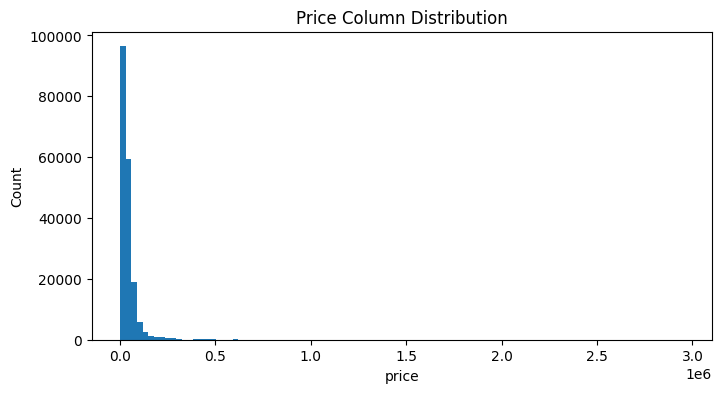

In [6]:
plt.figure(figsize=(8,4))
plt.hist(train_df['price'], bins=100)
plt.title("Price Column Distribution")
plt.xlabel("price")
plt.ylabel("Count")
plt.show()

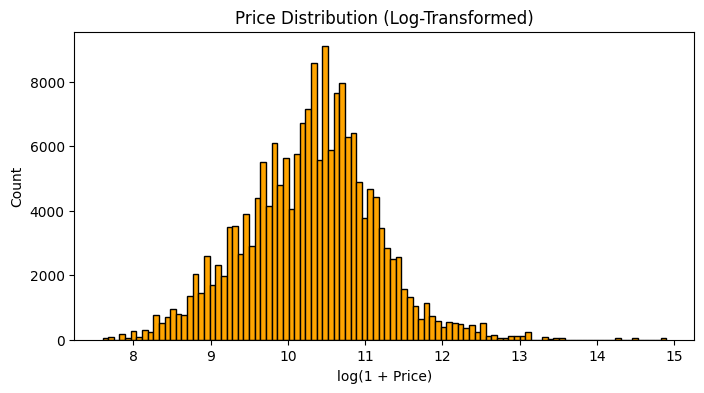

In [7]:

# Log-transformed price distribution
plt.figure(figsize=(8,4))
plt.hist(np.log1p(train_df['price']), bins=100, color='orange', edgecolor='black')
plt.title("Price Distribution (Log-Transformed)")
plt.xlabel("log(1 + Price)")
plt.ylabel("Count")
plt.show()


**Decribe Summary**
* 188,533 train data
* 2 numerical features model_year (correct range), mileage (the range is correct, no minus)
* Price columns is target variable. Price is highly right-skewed. in training data, more than 75%, are below 500k $

In [8]:
train_df.brand.unique()

array(['MINI', 'Lincoln', 'Chevrolet', 'Genesis', 'Mercedes-Benz', 'Audi',
       'Ford', 'BMW', 'Tesla', 'Cadillac', 'Land', 'GMC', 'Toyota',
       'Hyundai', 'Volvo', 'Volkswagen', 'Buick', 'Rivian', 'RAM',
       'Hummer', 'Alfa', 'INFINITI', 'Jeep', 'Porsche', 'McLaren',
       'Honda', 'Lexus', 'Dodge', 'Nissan', 'Jaguar', 'Acura', 'Kia',
       'Mitsubishi', 'Rolls-Royce', 'Maserati', 'Pontiac', 'Saturn',
       'Bentley', 'Mazda', 'Subaru', 'Ferrari', 'Aston', 'Lamborghini',
       'Chrysler', 'Lucid', 'Lotus', 'Scion', 'smart', 'Karma',
       'Plymouth', 'Suzuki', 'FIAT', 'Saab', 'Bugatti', 'Mercury',
       'Polestar', 'Maybach'], dtype=object)

In [9]:
train_df.model.unique()

array(['Cooper S Base', 'LS V8', 'Silverado 2500 LT', ..., 'e-Golf SE',
       'Integra w/A-Spec Tech Package', 'IONIQ Plug-In Hybrid SEL'],
      dtype=object)

In [10]:
train_df.fuel_type.unique()

array(['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel',
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

In [11]:
train_df.sample(10).engine.unique()

array(['240.0HP 3.0L V6 Cylinder Engine Diesel Fuel',
       '332.0HP 3.7L V6 Cylinder Engine Gasoline Fuel',
       '365.0HP 2.5L 4 Cylinder Engine Gasoline Fuel',
       '420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel',
       '333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel',
       '382.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel',
       '445.0HP 4.4L 8 Cylinder Engine Gasoline Fuel',
       '333.0HP 3.2L Straight 6 Cylinder Engine Gasoline Fuel',
       '560.0HP 4.0L 8 Cylinder Engine Gasoline Fuel',
       '572.0HP 3.8L Flat 6 Cylinder Engine Gasoline Fuel'], dtype=object)

* ***fuel_type*** excellence categories feature. NaN values are mostly electric motor car. this insight are benefit to model too.
* ***engine*** text feature, the crucial information inside are the Horsepower (HP), The engine Liter, Electric, V engine are useful for predict too.

In [12]:
train_df.ext_col.unique()[:20]

array(['Yellow', 'Silver', 'Blue', 'Black', 'White',
       'Snowflake White Pearl Metallic', 'Gray', 'Green',
       'Santorini Black Metallic', 'Purple', 'Ebony Twilight Metallic',
       'Red', 'Magnetite Black Metallic', 'Diamond Black', 'Vega Blue',
       'Beige', 'Gold', 'Platinum White Pearl', 'Metallic',
       'White Frost Tri-Coat'], dtype=object)

In [13]:
train_df.int_col.unique()[:20]

array(['Gray', 'Beige', 'Black', '–', 'Blue', 'White', 'Red', 'Brown',
       'Dark Galvanized', 'Parchment.', 'Boulder', 'Orange',
       'Medium Earth Gray', 'Ebony', 'Canberra Beige', 'Jet Black',
       'Silver', 'Light Platinum / Jet Black', 'Macchiato/Magmagrey',
       'Gold'], dtype=object)

* ***ext_col***, ***int_col*** are high cardinality categories feature, if we could normalize/standardize. it will be useful for model

In [14]:
train_df.accident.unique()

array(['None reported', 'At least 1 accident or damage reported', nan],
      dtype=object)

In [15]:
train_df.clean_title.unique()

array(['Yes', nan], dtype=object)

* ***accident***, ***clean_title*** there are nan values we have to deal with in next section

In [16]:
train_df['year_brand_model'] = train_df['model_year'].map(str) + ' ' + train_df['brand'] + ' ' + train_df['model']

In [7]:
# Brand groups
premium = {'BMW','Audi','Mercedes-Benz','Lexus','Jaguar','Cadillac','Acura','Infiniti','Lincoln','Volvo'}
supercar = {"Porsche","McLaren","Rolls-Royce","Maserati","Bentley",
            "Ferrari","Aston","Lamborghini","Lotus","Bugatti","Maybach"}

# Add car_class
train_df["car_class"] = train_df["brand"].map(
    lambda b: "Supercar" if b in supercar else "Premium" if b in premium else "Regular"
)

### ***Outliner Dectection***

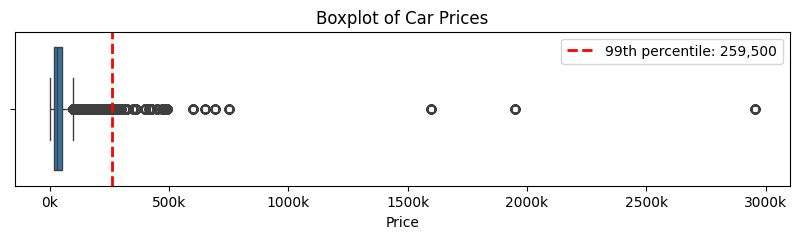

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Formatter function for 'k' style
def k_formatter(x, pos):
    return f'{int(x/1000)}k'

# Calculate 99th percentile
p99 = train_df['price'].quantile(0.99)

plt.figure(figsize=(10,2))
sns.boxplot(x=train_df['price'])

plt.title("Boxplot of Car Prices")
plt.xlabel("Price")

# Apply formatter
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(k_formatter))

# Add red line at 99th percentile
plt.axvline(p99, color='red', linestyle='--', linewidth=2, label=f'99th percentile: {p99:,.0f}')

# Add legend
plt.legend()

plt.show()


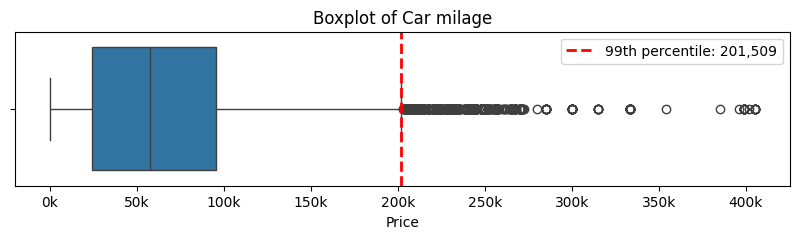

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Formatter function for 'k' style
def k_formatter(x, pos):
    return f'{int(x/1000)}k'

# Calculate 99th percentile
p99 = train_df['milage'].quantile(0.99)

plt.figure(figsize=(10,2))
sns.boxplot(x=train_df['milage'])

plt.title("Boxplot of Car milage")
plt.xlabel("Price")

# Apply formatter
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(k_formatter))

# Add red line at 99th percentile
plt.axvline(p99, color='red', linestyle='--', linewidth=2, label=f'99th percentile: {p99:,.0f}')

# Add legend
plt.legend()

plt.show()


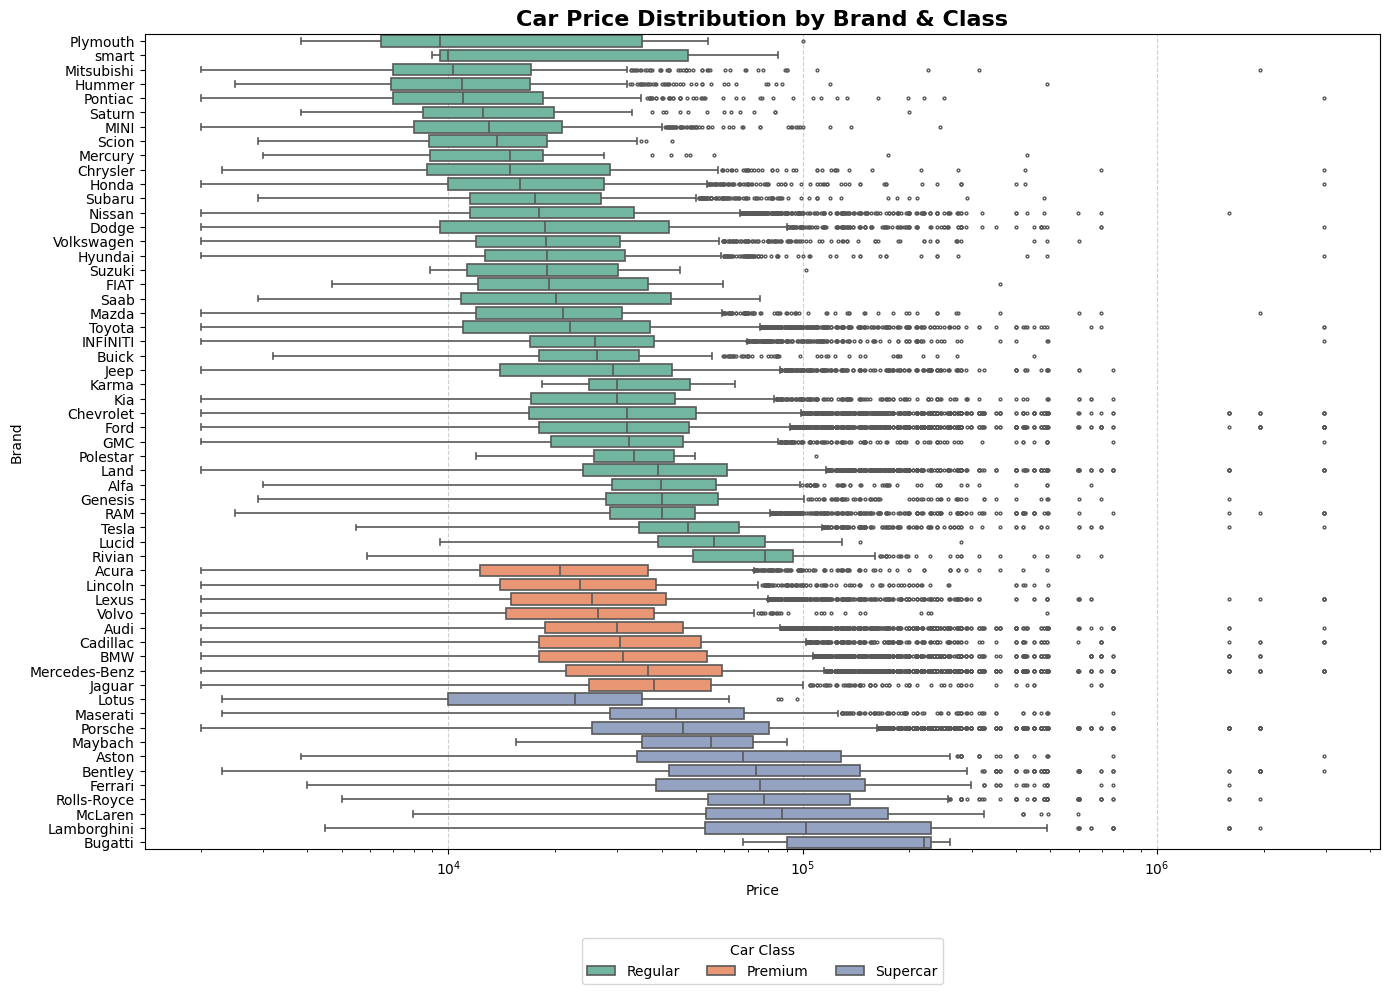

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import pandas as pd

# Sort brands by class then median price
class_order = ["Regular","Premium","Supercar"]
brand_order = (train_df.groupby(["car_class","brand"])["price"]
               .median()
               .reset_index()
               .assign(car_class=lambda d: pd.Categorical(d.car_class, class_order, ordered=True))
               .sort_values(["car_class","price"])["brand"])

plt.figure(figsize=(14,10))
sns.boxplot(y="brand", x="price", data=train_df, orient="h",
            order=brand_order, hue="car_class", palette="Set2",
            fliersize=2, linewidth=1.2)

plt.title("Car Price Distribution by Brand & Class", fontsize=16, weight="bold")
plt.xlabel("Price"); plt.ylabel("Brand")
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x,_: f'{int(x/1000)}k'))
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Legend moved to bottom, horizontal
plt.legend(title="Car Class", loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.xscale('log')
plt.tight_layout()
plt.show()


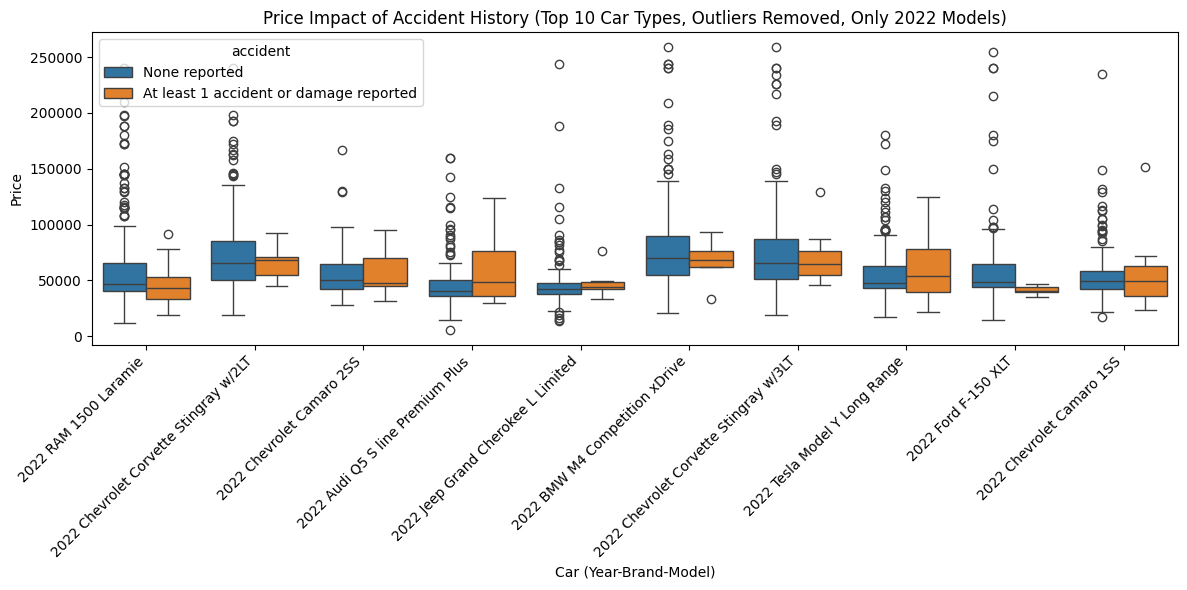

In [21]:

# --- Step 1: Find top 5 cars ---
top_cars = train_df[train_df['model_year'] == 2022]['year_brand_model'].value_counts().head(10).index

# --- Step 2: Remove outliers globally (1st–99th percentile) ---
low, high = train_df['price'].quantile([0.01, 0.99])
df_cleaned = train_df[(train_df['price'] >= low) & (train_df['price'] <= high)]

# --- Step 3: Boxplot comparison ---
plt.figure(figsize=(12,6))
sns.boxplot(
    x="year_brand_model",
    y="price",
    hue="accident",
    data=df_cleaned[df_cleaned['year_brand_model'].isin(top_cars)]
)
plt.xticks(rotation=45, ha="right")
plt.title("Price Impact of Accident History (Top 10 Car Types, Outliers Removed, Only 2022 Models)")
plt.ylabel("Price")
plt.xlabel("Car (Year-Brand-Model)")
plt.tight_layout()
plt.show()


* Accident history significantly reduces resale value, especially for sports/luxury models (BMW, Corvette, Tesla). For mainstream SUVs and trucks, the penalty exists but is smaller and sometimes overlaps with non-accident cars.

C:\Users\2082855\AppData\Local\Temp\ipykernel_3068\258658280.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y="accident", x="price", data=train_df, orient="h", showfliers=False,palette="Set2")


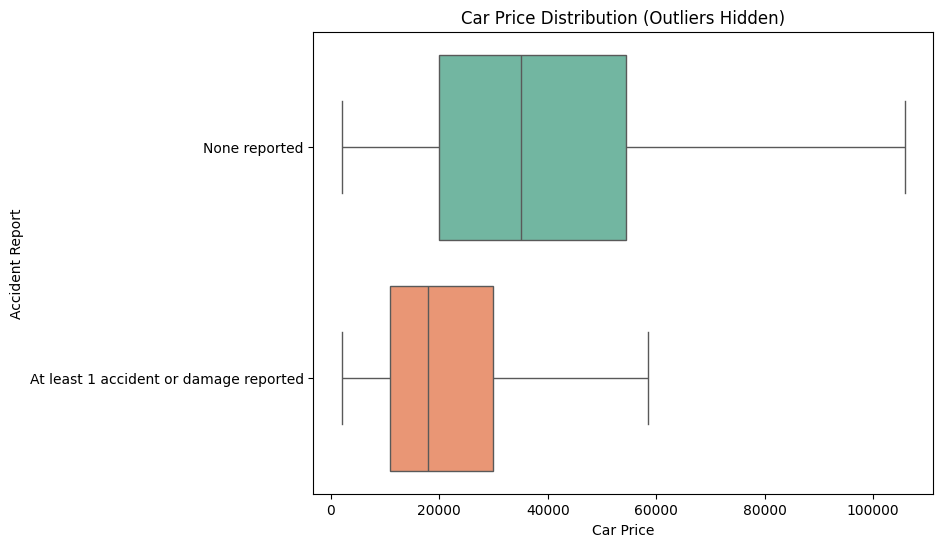

In [22]:
plt.figure(figsize=(8,6))
sns.boxplot(y="accident", x="price", data=train_df, orient="h", showfliers=False,palette="Set2")

plt.ylabel("Accident Report")
plt.xlabel("Car Price")
plt.title("Car Price Distribution (Outliers Hidden)")
plt.show()


C:\Users\2082855\AppData\Local\Temp\ipykernel_3068\99173076.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="model_year", y="price", data=train_df, showfliers=False, palette="Set2")


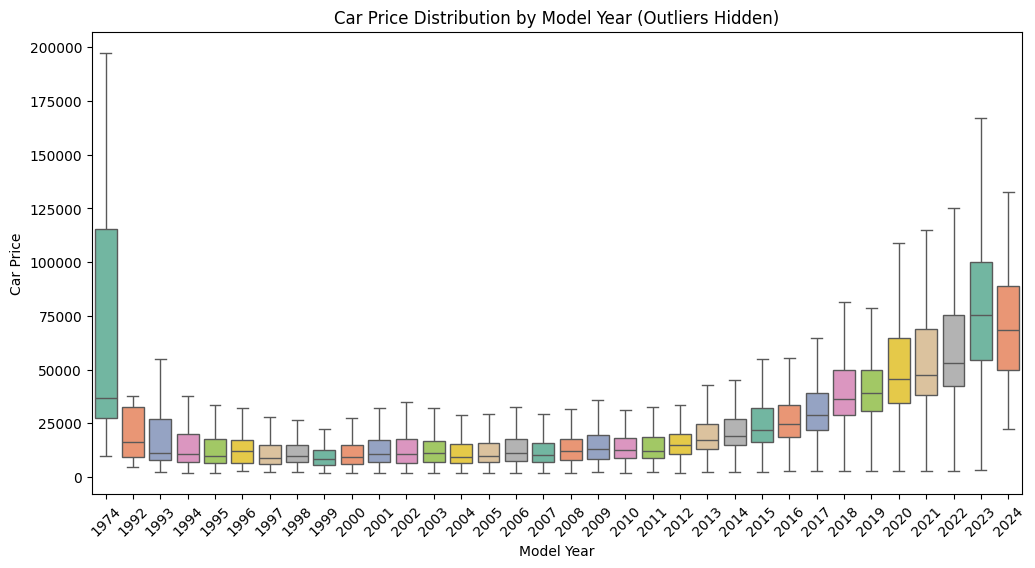

In [23]:
plt.figure(figsize=(12,6))
sns.boxplot(x="model_year", y="price", data=train_df, showfliers=False, palette="Set2")

plt.xlabel("Model Year")
plt.ylabel("Car Price")
plt.title("Car Price Distribution by Model Year (Outliers Hidden)")
plt.xticks(rotation=45)
plt.show()


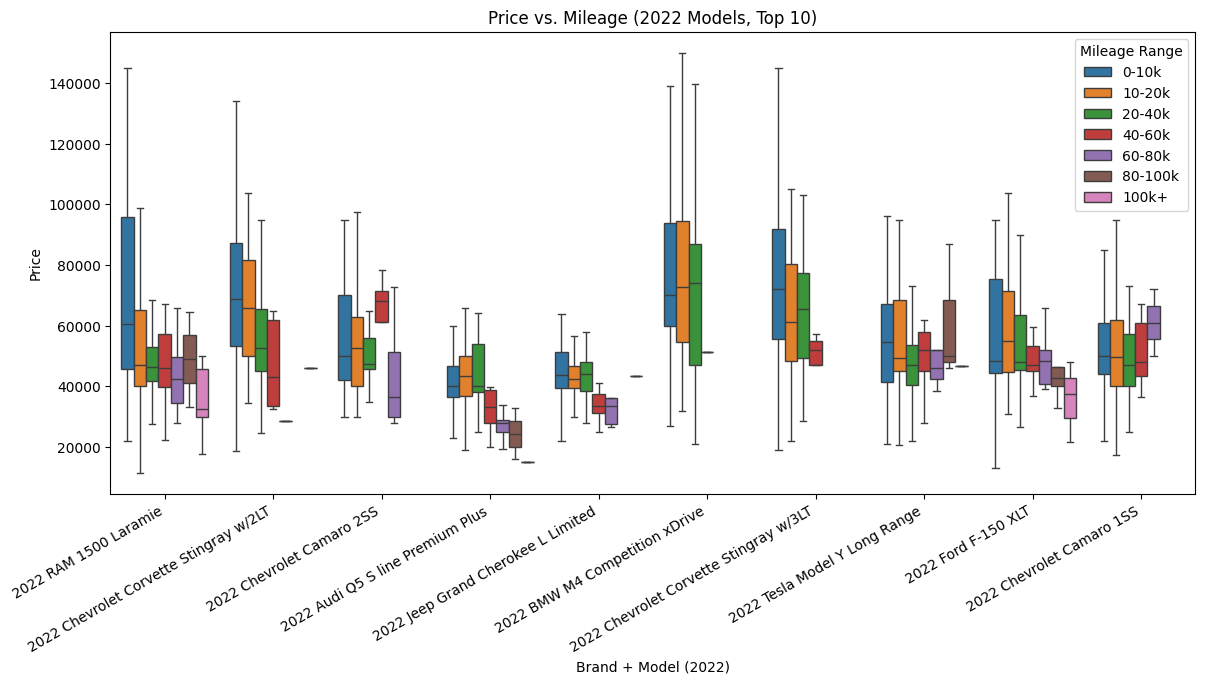

In [24]:

# --- Filter to 2022 models only ---
df_2022 = train_df[train_df['model_year'] == 2022].copy()

# --- Create mileage bins ---
bins = [0, 10000, 20000, 40000, 60000, 80000, 100000, df_2022['milage'].max()]
labels = ['0-10k','10-20k','20-40k','40-60k','60-80k','80-100k','100k+']
df_2022['mileage_bin'] = pd.cut(df_2022['milage'], bins=bins, labels=labels, right=False)

# --- Boxplot: Price vs. Mileage bins for each car (top 5 frequent models) ---
top10 = df_2022['year_brand_model'].value_counts().head(10).index
df_plot = df_2022[df_2022['year_brand_model'].isin(top10)]

plt.figure(figsize=(14,6))
sns.boxplot(
    data=df_plot,
    x='year_brand_model',
    y='price',
    hue='mileage_bin',
    showfliers=False
)
plt.title("Price vs. Mileage (2022 Models, Top 10)")
plt.xticks(rotation=30, ha='right')
plt.ylabel("Price")
plt.xlabel("Brand + Model (2022)")
plt.legend(title="Mileage Range")
# plt.yscale('log')  # keep scale readable if prices vary a lot
plt.show()


* Mileage is a clear driver of depreciation across these 2022 models. Luxury and performance cars lose value more dramatically with mileage, while normal car show steadier pricing but still drop after used a while.

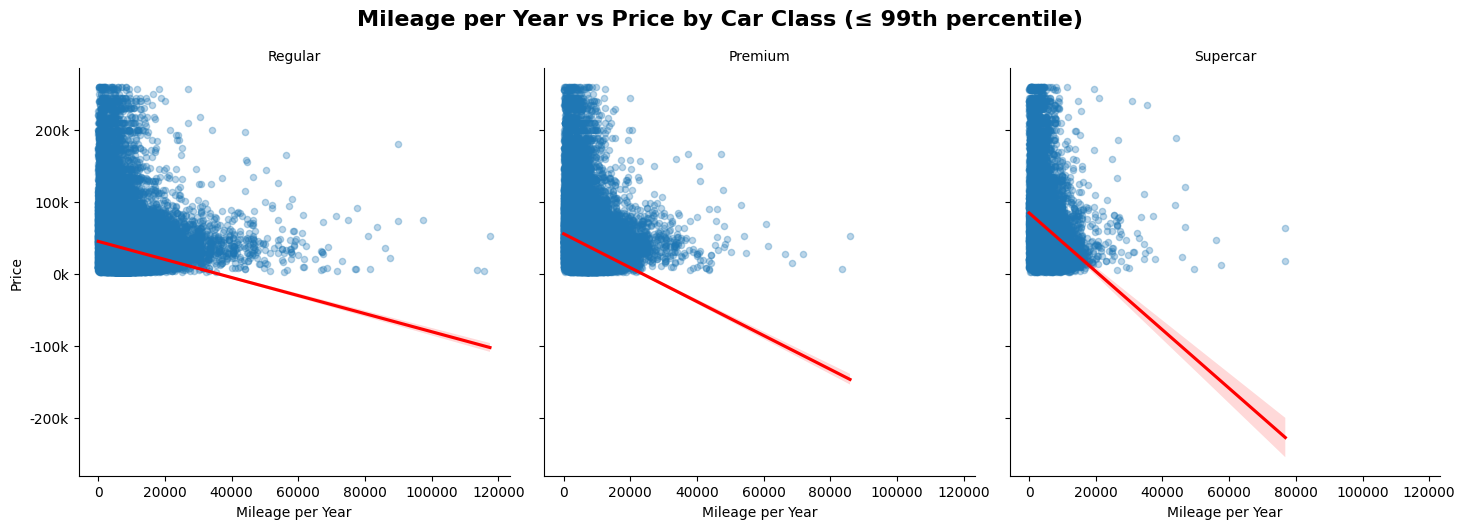

In [26]:
train_df["car_age"] = 2025 - train_df["model_year"]

# Ensure mileage_per_year exists
if "mileage_per_year" not in train_df.columns:
    train_df["mileage_per_year"] = train_df["milage"] / train_df["car_age"].replace(0, 1)

# Crop at 99th percentile of price
p99 = train_df["price"].quantile(0.99)
df_crop = train_df[train_df["price"] <= p99]

# Facet by car_class (Regular, Premium, Supercar)
g = sns.lmplot(
    x="mileage_per_year", y="price", data=df_crop,
    col="car_class", col_order=["Regular", "Premium", "Supercar"],
    scatter_kws={"alpha":0.3, "s":20},
    line_kws={"color":"red"},
    height=5, aspect=1
)

g.set_axis_labels("Mileage per Year", "Price")
g.set_titles("{col_name}")

# Format y-axis in 'k'
for ax in g.axes.flatten():
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x,_: f'{int(x/1000)}k'))

plt.suptitle("Mileage per Year vs Price by Car Class (≤ 99th percentile)", 
             y=1.05, fontsize=16, weight="bold")
plt.show()


### Hypercar handle.

### 1. Check Duplicate Records


In [8]:
print("duplicate rows of train_df ", train_df.duplicated().sum())
print("duplicate rows of test_df ", test_df.duplicated().sum())

duplicate rows of train_df  0
duplicate rows of test_df  0


### 2. Check Null Value

In [9]:
pd.concat([train_df.isna().sum().rename('null train.csv'), test_df.isna().sum().rename('null test.csv')], axis=1)

,null train.csv,null test.csv
id,0,0.0
brand,0,0.0
model,0,0.0
model_year,0,0.0
milage,0,0.0
fuel_type,5083,3383.0
engine,0,0.0
transmission,0,0.0
ext_col,0,0.0
int_col,0,0.0


### 3. Data Cleasing

* **fuel_type**, when value is NULL, Mostly It be the electric car, but some are also engine.

In [10]:
train_df.accident.value_counts(dropna=False) / len(train_df)

accident
None reported                             0.766518
At least 1 accident or damage reported    0.220476
NaN                                       0.013006
Name: count, dtype: float64

In [11]:
train_df.accident.fillna('None reported', inplace=True)
test_df.accident.fillna('None reported', inplace=True)

C:\Users\2082855\AppData\Local\Temp\ipykernel_38336\110054860.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df.accident.fillna('None reported', inplace=True)
C:\Users\2082855\AppData\Local\Temp\ipykernel_38336\110054860.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

* **accident** column has only 1% missing values, we can assume those are "No Accident" cars. So we will fill NaN with "No Accident" and convert to binary 0/1.

In [12]:
train_df.clean_title.value_counts(dropna=False) / len(train_df)

clean_title
Yes    0.886391
NaN    0.113609
Name: count, dtype: float64

In [13]:
# Reclassify clean_title based on accident + missing

train_df['clean_title'] = train_df.apply(
    lambda x: 'No' if (pd.isna(x['clean_title']) 
                       and x['accident'] == 'At least 1 accident or damage reported') 
              else 'Yes',
    axis=1
)

* Assume ***clean_title*** is 'YES' when never accident reported.

In [14]:
train_df.fuel_type.value_counts(dropna=False) / len(train_df)

fuel_type
Gasoline          0.880164
Hybrid            0.036238
E85 Flex Fuel     0.028674
NaN               0.026961
Diesel            0.020978
–                 0.004143
Plug-In Hybrid    0.002763
not supported     0.000080
Name: count, dtype: float64

In [15]:
def fill_nan_and_others_engine_column(df):

    # Define keywords for electric engines
    electric_keywords = [
        "Electric Motor", "Motor Electric",
        "Electric", "Dual Motor", "Electric Fuel", "Standard Range Battery",
        "Ah", "kWh", "Battery"
    ]

    # 1. Condition for electric-related but NOT 'Electric Hybrid'
    is_electric = (
        df['engine'].str.contains('|'.join(electric_keywords), case=False, na=False) &
        ~df['engine'].str.contains("Hybrid", case=False, na=False)
    )

    # fill NaN in engine OR electric engines → "Electric Power"
    df['fuel_type'] = np.where(
        (df['engine'].isna()) | (is_electric),
        "Electric Power",
        df['fuel_type']
    )

    # 2. Condition for hybrid engines in NaN fuel_type

    is_hybrid = df['engine'].str.contains("Hybrid", case=False, na=False)

    df['fuel_type'] = np.where(
        (df['engine'].isna()) | (is_hybrid),
        "Hybrid",
        df['fuel_type']
    )

    # 3. Fill remaining NaN, 'not-support', '–' fuel_type with 'Others'
    df['fuel_type'] = df['fuel_type'].replace(['not supported', '–', np.nan], 'Others')

    return df


In [16]:
train_df = fill_nan_and_others_engine_column(train_df)
test_df = fill_nan_and_others_engine_column(test_df)

* Enrich ***fuel_type*** from some Nan values to 'Electric Power', and assign 'not supported', '–', np.nan to 'Others'

In [17]:
train_df.fuel_type.value_counts(dropna=False)

fuel_type
Gasoline          165018
Hybrid              7086
Electric Power      6176
E85 Flex Fuel       5404
Diesel              3953
Others               882
Plug-In Hybrid        14
Name: count, dtype: int64

### 3. Feature Engineering
- add car_age
- add is_premium_brand
- add is_supercar_brand
- extract horsepower, size engine
- normalize transmission 
- cross_categories_feature

In [18]:
import itertools

def add_car_age_column(df, current_year=2024):
    df['car_age'] = current_year - df['model_year']
    return df

def add_use_mileage_per_yr_column(df):
    df['mileage_per_year'] = df['milage'] / df['car_age'].replace(0, 1)  # Avoid division by zero
    return df

def add_is_accident_column(df):
    df['is_accident'] = np.where(df['accident'] == 'None reported', 0, 1)
    return df

def add_is_clean_title_column(df):
    df['is_clean_title'] = np.where(df['clean_title'] == 'Yes', 1, 0)
    return df

def add_is_premium_brand_column(df):
    premium_brands = ['BMW', 'Audi', 'Mercedes-Benz', 'Lexus', 'Jaguar', 'Cadillac', 'Acura', 'Infiniti', 'Lincoln', 'Volvo']
    df['is_premium_brand'] = df['brand'].isin(premium_brands).astype(int)
    return df

def add_is_supercar_brand_column(df):
    supercar_brands = ["Porsche", "McLaren", "Rolls-Royce", "Maserati", "Bentley", "Ferrari", "Aston", "Lamborghini", "Lotus", "Bugatti", "Maybach"]
    df['is_supercar_brand'] = df['brand'].isin(supercar_brands).astype(int)
    return df

def extract_engine_specs(df):
    # Extract horsepower (numbers before HP)
    df['horsepower'] = (
        df['engine']
        .str.extract(r'(\d+(?:\.\d+)?)\s*HP', expand=False)
        .astype(float)
    )

    # Extract engine size (liters before L)
    df['engine_size'] = (
        df['engine']
        .str.extract(r'(\d+(?:\.\d+)?)\s*L', expand=False)
        .astype(float)
    )

    df['cylinder'] = df['engine'].str.extract(r'(\d+)\s*CYLINDER', expand=False)
    df['cylinder'] = df['cylinder'].fillna(df['engine'].str.extract(r'V(\d+)', expand=False))
    df['cylinder'] = pd.to_numeric(df['cylinder'], errors='coerce')

    return df

def impute_engine_specs(df, hp_mean, size_mean, cyl_mode):
    """Impute missing values with training-set statistics"""
    df['horsepower'] = df['horsepower'].fillna(hp_mean)
    df['engine_size'] = df['engine_size'].fillna(size_mean)
    df['cylinder'] = df['cylinder'].fillna(cyl_mode)
    return df

def normalize_transmission(df, col="transmission"):

    df[col] = df[col].replace({
        # Automatic types
        r'.*A/T.*': 'A/T',          
        r'.*M/T.*': 'M/T',          
        r'.*Automatic.*': 'A/T',   
        r'.*Auto-Shift.*': 'A/T',
        r'.*Dual Shift.*': 'A/T',
        r'.*Single-Speed*': 'A/T',

        r'.*CVT.*': 'CVT',          
        r'.*Dual Shift*': 'DCT',
          
        # Manual types
        r'.*M/T.*': 'M/T',
        r'.*Manual.*': 'M/T',
        r'.*Speed MT.*': 'M/T',
        r'.*Mt.*': 'M/T',          
        r'.*At/Mt.*': 'M/T',

    }, regex=True)

    # Force any unrecognized values into OTHERS
    df[col] = df[col].where(df[col].isin(['A/T', 'M/T', 'CVT', 'DCT']), 'OTHERS')

    return df


# Shared color keywords for normalization
COLOR_KEYWORDS = {
    "BLACK":   ["BLACK", "JET BLACK", "EBONY", "ONYX", "RAVEN", "OBSIDIAN", "GLOBAL BLACK",
                "CHARCOAL", "SATIN BLACK", "BLK", "GRAPHITE", "TITAN BLACK", "SAPPHIRE"],
    "WHITE":   ["WHITE", "PEARL", "ALPINE", "SNOW", "GLACIAL", "IVORY", "DIAMOND WHITE",
                "CERAMIC", "ICE", "PORTLAND", "ULTRA WHITE"],
    "GRAY":    ["GRAY", "GRAPHITE", "GRANITE", "SHADOW", "MAGNETIC", "SATIN STEEL",
                "DAYTONA GRAY", "SLATE", "MAGMAGREY", "GUN METAL", "DARK SLATE"],
    "SILVER":  ["SILVER", "PLATINUM", "BRILLIANT SILVER", "LUNAR SILVER", "ATOMIC SILVER"],
    "BLUE":    ["BLUE", "NAVY", "AZURE", "BLU", "INDIGO", "ANTIMATTER", "CHARLES BLUE", "NAVY PIER"],
    "RED":     ["RED", "MAROON", "CRIMSON", "SOUL RED", "VELVET RED", "ROSSO",
                "DELMONICO", "RIOJA", "ADRENALINE", "HOTSPUR", "EXPRESS RED"],
    "GREEN":   ["GREEN", "CYPRESS", "DEEP CYPRESS"],
    "BROWN":   ["BROWN", "BRONZE", "COFFEE", "MOCHA", "ESPRESSO", "WALNUT", "SADDLE", "MESA"],
    "BEIGE":   ["BEIGE", "PARCHMENT", "SANDSTONE", "MACCHIATO", "SILK BEIGE", "SHARA BEIGE", "CASHMERE"],
    "GOLD":    ["GOLD", "CHAMPAGNE"],
    "ORANGE":  ["ORANGE", "FIRECRACKER", "COPPER"],
    "YELLOW":  ["YELLOW"],
    "PURPLE":  ["PURPLE", "VIOLET", "PLUM"]
}

def normalize_color_column(df, col):

    def map_color(val):
        val = str(val).upper()
        if val.strip() in ["–", "-", "NAN", "NONE"]:
            return "OTHERS"
        
        for norm, keywords in COLOR_KEYWORDS.items():
            if any(k in val for k in keywords):
                return norm
        return "OTHERS"
    
    df[col] = df[col].apply(map_color)
    return df

def normalize_colors(df, ext_col="ext_col", int_col="int_col"):
    """
    Apply color normalization for both exterior and interior columns.
    """
    df = normalize_color_column(df, ext_col)
    df = normalize_color_column(df, int_col)
    return df


def add_cross_features(df, categorical_cols, sep="_"):
    """
    Automatically generate pairwise cross features for categorical columns.
    Example: brand + ext_col -> brand_ext_col
    """
    df = df.copy()
    for col1, col2 in itertools.combinations(categorical_cols, 2):
        new_col = f"cf_{col1}{sep}{col2}"
        df[new_col] = df[col1].astype(str) + sep + df[col2].astype(str)
    return df

In [ ]:
train_hp_mean, train_size_mean, train_cyl_mode

In [19]:
train_df_copy = train_df.copy()

In [ ]:

train_df_copy = add_car_age_column(train_df_copy)

train_df_copy = add_is_accident_column(train_df_copy)
train_df_copy = add_is_clean_title_column(train_df_copy)

train_df_copy = add_is_premium_brand_column(train_df_copy)
train_df_copy = add_is_supercar_brand_column(train_df_copy)
train_df_copy = extract_engine_specs(train_df_copy)

# Step 2: Compute statistics from train
train_hp_mean = train_df_copy['horsepower'].mean()
train_size_mean = train_df_copy['engine_size'].mean()
train_cyl_mode = train_df_copy['cylinder'].mode()[0]

# Calculate training-set statistics for imputation
train_df_copy  = impute_engine_specs(train_df_copy, 
                                train_hp_mean, 
                                train_size_mean, 
                                train_cyl_mode)
train_df_copy = normalize_transmission(train_df_copy, col="transmission")
train_df_copy = normalize_colors(train_df_copy, 
                                 ext_col="ext_col", 
                                 int_col="int_col")

## add feature: mileage_per_year
train_df_copy = add_use_mileage_per_yr_column(train_df_copy)

# Pick categorical features to cross
categorical = ['model','fuel_type', 'transmission', 'ext_col', 'int_col']
train_df_copy = add_cross_features(train_df_copy, categorical)

cross_feature_cols = [c for c in train_df_copy.columns if c.startswith('cf_')]

## add log price, mileage, car_age
train_df_copy['log_price'] = np.log1p(train_df_copy['price'])

In [80]:
train_hp_mean, train_size_mean, train_cyl_mode

(np.float64(343.263856151062), np.float64(3.7753963758352356), np.float64(6.0))

Text(0.5, 1.0, 'Numerical feature to correlation Matrix')

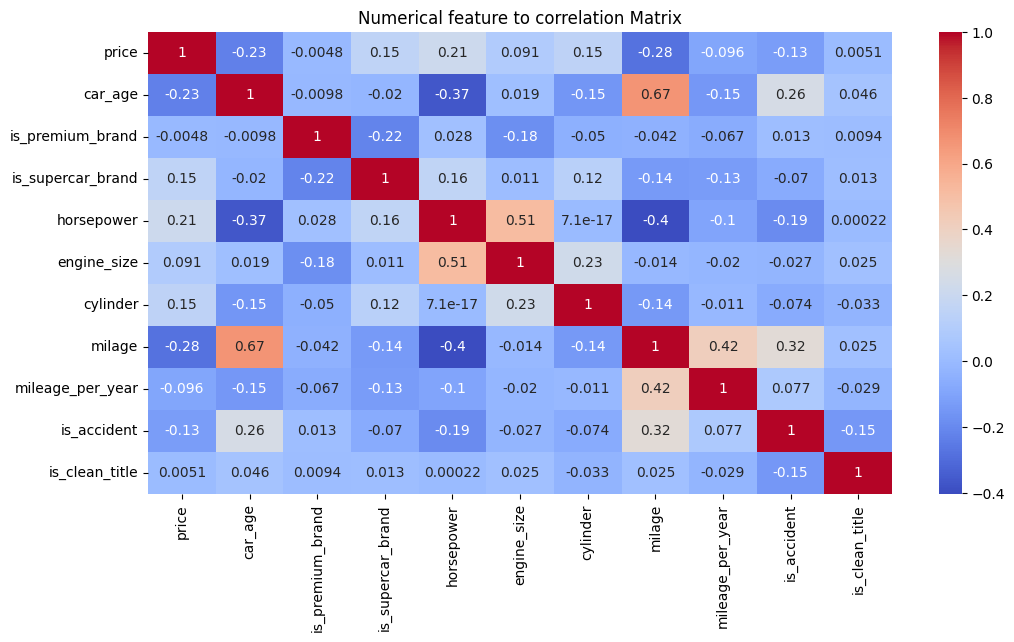

In [42]:
plt.figure(figsize=(12, 6))
sns.heatmap(train_df_copy[['price',
                           'car_age', 
                           'is_premium_brand', 
                           'is_supercar_brand', 
                           'horsepower', 
                           'engine_size', 
                           'cylinder', 
                           'milage',
                           'mileage_per_year',
                           'is_accident',
                           'is_clean_title']].corr(),cmap='coolwarm', annot=True)
plt.title('Numerical feature to correlation Matrix')

### 4. ML Modeling & Validation

In [23]:
import numpy as np
import pandas as pd
import json

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

In [ ]:

# ------------------------
# 1. Target & Features
# ------------------------
target = "log_price"

features = [
    'brand', 'model', 'model_year', 'milage', 'fuel_type',
    'transmission', 'ext_col', 'int_col',
    'is_premium_brand', 'is_supercar_brand',
    'car_age', 'is_accident', 'is_clean_title',
    'horsepower', 'engine_size', 'cylinder', 'mileage_per_year'
]+ cross_feature_cols

X = train_df_copy[features]
y = train_df_copy[target]

categorical = ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col'] + cross_feature_cols
numeric = [col for col in features if col not in categorical]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', 'passthrough', numeric)
])

# ------------------------
# 2. Base Models
# ------------------------
models = {
    "XGBRegressor": xgb.XGBRegressor(
        n_estimators=2000, learning_rate=0.05, max_depth=8,
        subsample=0.8, colsample_bytree=0.8,
        objective="reg:squarederror", random_state=42, n_jobs=-1
    ),
    "LGBMRegressor": lgb.LGBMRegressor(
        n_estimators=2000, learning_rate=0.05, max_depth=-1,
        subsample=0.8, colsample_bytree=0.8,
        objective="regression", random_state=42, n_jobs=-1
    ),
    "CatBoostRegressor": CatBoostRegressor(
        iterations=2000, learning_rate=0.05, depth=8,
        loss_function="RMSE", verbose=0, random_state=42
    ),
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=600, max_depth=20, random_state=42, n_jobs=-1
    )
}

# ------------------------
# 3. Cross-validation loop
# ------------------------
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = {name: [] for name in models.keys()}

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"\nFold {fold+1}")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Preprocess
    X_train_prep = preprocessor.fit_transform(X_train)
    X_test_prep = preprocessor.transform(X_test)

    # Train & Evaluate each model
    for name, model in models.items():
        model.fit(X_train_prep, y_train)
        y_pred_log = model.predict(X_test_prep)
        y_pred = np.expm1(y_pred_log)   # back-transform
        y_true = np.expm1(y_test)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        results[name].append(rmse)
        print(f"{name} RMSE: {rmse:,.0f}")

# ------------------------
# 4. Visualization
# ------------------------
avg_rmse = {name: np.mean(scores) for name, scores in results.items()}

plt.figure(figsize=(10,6))
plt.boxplot(results.values(), labels=results.keys())
plt.ylabel("RMSE")
plt.title("10-Fold CV RMSE Comparison (Lower is Better)")
plt.show()

print("\nAverage RMSE per model:")
for name, score in avg_rmse.items():
    print(f"{name}: {score:,.0f}")


with open("results.json", "w") as f:
    json.dump(results, f, indent=4)

In [52]:
import json
# Load
with open("results.json", "r") as f:
    results = json.load(f)

In [25]:
# ------------------------
# 1. Define binary target (is_outlier)
# ------------------------
# Example: mark outliers as prices > 99th percentile

threshold = train_df_copy["price"].quantile(0.99)
train_df_copy["is_outlier"] = (train_df_copy["price"] > threshold).astype(int)

y_class = train_df_copy["is_outlier"]   # classifier target
y_reg   = train_df_copy["price"]        # regression target

# ------------------------
# 2. Features
# ------------------------
features = [
    'brand', 'model', 'model_year', 'milage', 'fuel_type',
    'transmission', 'ext_col', 'int_col',
    'is_premium_brand', 'is_supercar_brand',
    'car_age', 'is_accident', 'is_clean_title',
    'horsepower', 'engine_size', 'cylinder', 'mileage_per_year'
] + cross_feature_cols

X = train_df_copy[features]

categorical = ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col'] + cross_feature_cols
numeric = [col for col in features if col not in categorical]

# ------------------------
# 3. Models
# ------------------------
clf = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

reg = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

# ------------------------
# 4. Cross-validation loop
# ------------------------
kf = KFold(n_splits=10, shuffle=True, random_state=42)

rmse_scores = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y_class)):
    print(f"\nFold {fold+1}")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train_class, y_test_class = y_class.iloc[train_idx], y_class.iloc[test_idx]
    y_train_reg, y_test_reg = y_reg.iloc[train_idx], y_reg.iloc[test_idx]

    # ---- Stage 1: classifier pipeline
    preproc_clf = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', 'passthrough', numeric)
    ])
    clf_pipe = Pipeline(steps=[("preproc", preproc_clf), ("clf", clf)])
    clf_pipe.fit(X_train, y_train_class)
    y_pred_outlier = clf_pipe.predict(X_test)

    # ---- Stage 2: regression with is_outlier feature
    X_train_reg = X_train.copy()
    X_test_reg  = X_test.copy()

    X_train_reg["is_outlier_flag"] = y_train_class
    X_test_reg["is_outlier_flag"]  = y_pred_outlier

    preproc_reg = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', 'passthrough', numeric + ["is_outlier_flag"])
    ])
    reg_pipe = Pipeline(steps=[("preproc", preproc_reg), ("reg", reg)])
    reg_pipe.fit(X_train_reg, y_train_reg)

    y_pred_reg = reg_pipe.predict(X_test_reg)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
    rmse_scores.append(rmse)
    print(f"Fold {fold+1} RMSE: {rmse:,.0f}")

print("\nAverage RMSE:", np.mean(rmse_scores))
print("Std RMSE:", np.std(rmse_scores))



Fold 1
Fold 1 RMSE: 71,816

Fold 2
Fold 2 RMSE: 69,511

Fold 3
Fold 3 RMSE: 66,914

Fold 4
Fold 4 RMSE: 75,268

Fold 5
Fold 5 RMSE: 86,024

Fold 6
Fold 6 RMSE: 62,343

Fold 7
Fold 7 RMSE: 77,181

Fold 8
Fold 8 RMSE: 80,015

Fold 9
Fold 9 RMSE: 75,028

Fold 10
Fold 10 RMSE: 82,672

Average RMSE: 74677.15661855417
Std RMSE: 6893.242210159921


In [54]:
with open("stacking_model_results.json", "w") as f:
    json.dump(rmse_scores, f, indent=4)

In [55]:
results['2_stack_model'] = rmse_scores

C:\Users\2082855\AppData\Local\Temp\ipykernel_38336\2538607478.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_results.columns, y=df_results.mean(), palette="Set2")


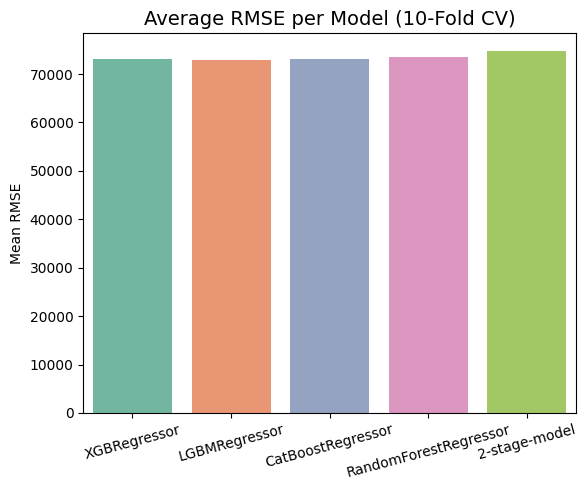

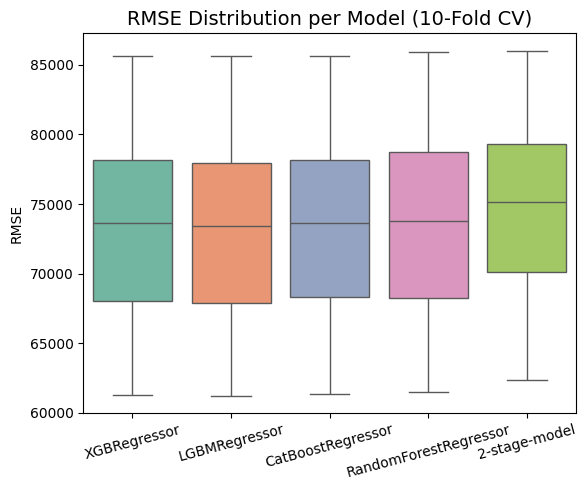

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# --- Bar Plot: Mean RMSE ---
plt.figure(figsize=(6,5))
sns.barplot(x=df_results.columns, y=df_results.mean(), palette="Set2")
plt.title("Average RMSE per Model (10-Fold CV)", fontsize=14)
plt.ylabel("Mean RMSE")
plt.xlabel("")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# --- Box Plot: RMSE Distribution ---
plt.figure(figsize=(6,5))
sns.boxplot(data=df_results, palette="Set2")
plt.title("RMSE Distribution per Model (10-Fold CV)", fontsize=14)
plt.ylabel("RMSE")
plt.xlabel("")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [56]:
# Convert to DataFrame
df_results = pd.DataFrame(results)

# Mean RMSE per model
mean_table = df_results.mean().sort_values().reset_index()
mean_table.columns = ["Model", "10CV_Mean_RMSE"]

# Compute difference from max value
max_val = mean_table["10CV_Mean_RMSE"].min()
mean_table["Diff_From_Best_Model"] = max_val - mean_table["10CV_Mean_RMSE"]

mean_table


,Model,10CV_Mean_RMSE,Diff_From_Best_Model
0,LGBMRegressor,72956.532787,0.000000
1,XGBRegressor,73074.922485,-118.389698
2,CatBoostRegressor,73167.173048,-210.640261
3,RandomForestRegressor,73423.369927,-466.837140
4,2_stack_model,74677.156619,-1720.623832


In [65]:
test_df_copy = test_df.copy()
# ------------------------
# 1. Apply feature functions to test_df
# ------------------------
test_df_copy = add_car_age_column(test_df_copy)
test_df_copy = add_is_accident_column(test_df_copy)
test_df_copy = add_is_clean_title_column(test_df_copy)
test_df_copy = add_is_premium_brand_column(test_df_copy)
test_df_copy = add_is_supercar_brand_column(test_df_copy)
test_df_copy = extract_engine_specs(test_df_copy)

# ------------------------
# 2. Impute missing engine specs using TRAIN statistics
# ------------------------
test_df_copy = impute_engine_specs(
    test_df_copy,
    train_hp_mean,      # mean horsepower from train
    train_size_mean,    # mean engine_size from train
    train_cyl_mode      # mode of cylinder from train
)

# ------------------------
# 3. Normalize categorical text (must be consistent with train)
# ------------------------
test_df_copy = normalize_transmission(test_df_copy, col="transmission")
test_df_copy = normalize_colors(test_df_copy, ext_col="ext_col", int_col="int_col")

# ------------------------
# 4. Add derived features
# ------------------------
test_df_copy = add_use_mileage_per_yr_column(test_df_copy)


# Pick categorical features to cross
categorical = ['model','fuel_type', 'transmission', 'ext_col', 'int_col']
test_df_copy = add_cross_features(test_df_copy, categorical)

cross_feature_cols = [c for c in test_df_copy.columns if c.startswith('cf_')]

# ⚠️ DO NOT add log_price to test_df (no target available)


In [67]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

# ------------------------
# 1. Target & Features
# ------------------------
target = "log_price"

features = [
    'brand', 'model', 'model_year', 'milage', 'fuel_type',
    'transmission', 'ext_col', 'int_col',
    'is_premium_brand', 'is_supercar_brand',
    'car_age', 'is_accident', 'is_clean_title',
    'horsepower', 'engine_size', 'cylinder', 'mileage_per_year'
] + cross_feature_cols

X = train_df_copy[features]
y = train_df_copy[target]

categorical = ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col'] + cross_feature_cols
numeric = [col for col in features if col not in categorical]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', 'passthrough', numeric)
])

# ------------------------
# 2. LightGBM Model
# ------------------------
lgbm = lgb.LGBMRegressor(
    n_estimators=2000, learning_rate=0.05, max_depth=-1,
    subsample=0.8, colsample_bytree=0.8,
    objective="regression", random_state=42, n_jobs=-1
)

# ------------------------
# 4. Train on Full Data
# ------------------------
X_full_prep = preprocessor.fit_transform(X)
lgbm.fit(X_full_prep, y)

# ------------------------
# 5. Predict on Test Set & Submit
# ------------------------
X_test_prep = preprocessor.transform(test_df_copy[features])
y_test_pred_log = lgbm.predict(X_test_prep)
y_test_pred = np.expm1(y_test_pred_log)

submission = pd.DataFrame({
    "id": test_df_copy["id"],    # change if Kaggle dataset uses different ID col
    "price": y_test_pred
})

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv created!")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18853
[LightGBM] [Info] Number of data points in the train set: 188533, number of used features: 9000
[LightGBM] [Info] Start training from score 10.291787


c:\Users\2082855\.conda\envs\used-car-price-prediction\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


✅ submission.csv created!


In [ ]:
# kaggle competitions submit -c playground-series-s4e9 -f submission.csv -m "Message"

In [ ]:
import joblib

# Save the preprocessor
joblib.dump(preprocessor, "./deployment_app/model/preprocessor.pkl")
print("✅ Preprocessor saved as preprocessor.pkl")
# Save model
joblib.dump(lgbm, "./deployment_app/model/lgbm_model.pkl")
print("✅ Model saved as lgbm_model.pkl")

✅ Preprocessor saved as preprocessor.pkl
✅ Model saved as lgbm_model.pkl


In [ ]:
# Save only the underlying Booster (safer across environments)
lgbm.booster_.save_model("./deployment_app/models/gbr_base.txt")
print("✅ Model saved as gbr_base.txt")

# Save the preprocessor
joblib.dump(preprocessor, "./deployment_app/model/preprocessor.pkl")
print("✅ Preprocessor saved as preprocessor.pkl")